In [45]:
import itertools

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import ttest_rel, shapiro, wilcoxon
from tqdm import tqdm

In [2]:
df = pd.read_csv('CC_1.csv')

## Check non-corrected p-values across segments

In [47]:
#store statistic
stat =  []

#store pvalue
pvalue = []
for segment in df.Tract_Segment.unique():
    #session 1 data
    ses1 = df.loc[df.Tract_Segment == segment, 'ses-01'].values
    #session 3 data
    ses3 = df.loc[df.Tract_Segment == segment, 'ses-03'].values
    
    
    st, pv = ttest_rel(ses1, ses3)
    
    stat.append(st)
    
    pvalue.append(pv)

Plot the non-corrected pvalues over segments

Text(0.5, 0.98, 'Uncorrected')

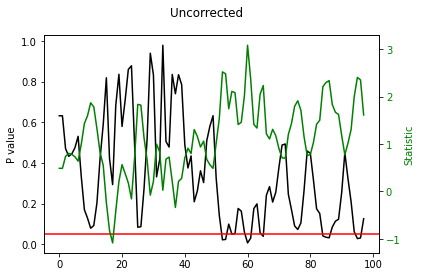

In [119]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(pvalue, label='P values', color='k')
ax2.plot(stat, label='Statistic', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax1.axhline(0.05, c='r')
plt.xlabel('Segment')
ax1.set_ylabel('P value', color='k')
ax2.set_ylabel('Statistic', color='g')
plt.suptitle('Uncorrected')

In [113]:
from statsmodels.stats.multitest import multipletests

In [117]:
multipletests(pvalue, 0.05, 'holm')[1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.66205845, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

Text(0.5, 0.98, 'With Holm-Bonferroni')

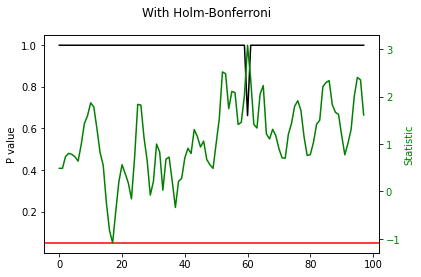

In [118]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(multipletests(pvalue, 0.05, 'holm')[1], label='P values', color='k')
ax2.plot(stat, label='Statistic', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax1.axhline(0.05, c='r')
plt.xlabel('Segment')
ax1.set_ylabel('P value', color='k')
ax2.set_ylabel('Statistic', color='g')
plt.suptitle('With Holm-Bonferroni')

## Conduct permutation test according to Nichols & Holmes (2001)

Using the single threshold test, the algorithm is as follows:

For each possible relabeling $i = 1,\dots,N$, note the maximum voxel statsitics for labeling i. I assume that voxel in our case is segment. We then take the $T^{max}$ distribution and calculate the critical threshold of (floor($\alpha N$) + 1)$^{th}$ member of  $T^{max}$

representing each original labeling (ses-1 & ses-2 in correct position) as 0 with flipped to be 1, we have the following combinations $2^n$ where n is the number of subjects

In [81]:
n = df.Subject_ID.unique().shape[0]

In [84]:
relabels = np.array([list(i) for i in itertools.product([0, 1], repeat=n)])

In [85]:
# confirm math holds
assert(len(relabels) == 2**n)

For the next step,  I find it easier to switch to numpy instead of tables/pandas

In [86]:
data = []
for segment in df.Tract_Segment.unique():
    #session 1 data
    ses1 = df.loc[df.Tract_Segment == segment, 'ses-01'].values
    #session 3 data
    ses3 = df.loc[df.Tract_Segment == segment, 'ses-03'].values
    
    data.append(np.stack([ses1, ses3]).T)

data = np.array(data)

We now have tensor data of size S x N x 2, where S is segments, N is subjects and 2 is the 2 days of testing

Permutation time:

In [90]:
tmax = []

for relabel in tqdm(relabels):
    data_perm = data.copy()
    
    data_perm[:,relabel==1,:] = data_perm[:,relabel==1,::-1]
    
    tmax.append(list(map(lambda x: ttest_rel(x[:,0], x[:,1])[0], data_perm)))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 262144/262144 [27:38<00:00, 158.04it/s]


In [91]:
tmax_actual = np.sort(np.max(tmax, axis=1))

In [102]:
tmax_actual

array([-1.07182276, -0.92968904, -0.86422665, ...,  8.14740036,
        8.47018404,  8.74106535])

(array([1.14600e+03, 3.65970e+04, 1.07305e+05, 8.28400e+04, 2.79180e+04,
        5.35700e+03, 8.35000e+02, 1.25000e+02, 1.60000e+01, 5.00000e+00]),
 array([-1.07182276, -0.09053395,  0.89075486,  1.87204367,  2.85333248,
         3.83462129,  4.8159101 ,  5.79719891,  6.77848773,  7.75977654,
         8.74106535]),
 <BarContainer object of 10 artists>)

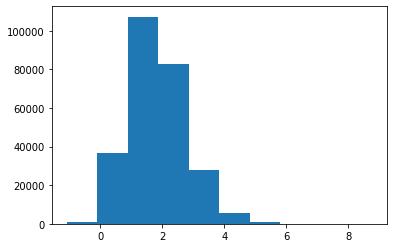

In [101]:
plt.hist(tmax_actual)

In [95]:
alpha=0.05

In [105]:
critical_thresh_ind = int(np.floor(2**n * alpha))

In [106]:
critical_thresh_ind

13107

**NOTE** It is not clear to me what the exact c+1 element is from Nichols & Holmes. Is it larger than c or lower than c? Either way, given the sheer number of permutations, the difference between these two sorted elements is extremely small.

In [107]:
critical_thresh = tmax_actual[-critical_thresh_ind]

In [108]:
critical_thresh

3.432375884501437

Omnibus test: is any statistic more than the critical threshold?

In [110]:
np.any(np.array(stat) > critical_thresh)

False

Not significant

BUT if it was significant sig_segments will hold the significant ones

In [120]:
sig_segments = np.where(np.array(stat) > critical_thresh)

In [121]:
sig_segments

(array([], dtype=int64),)

## Conduct permutation test per usual stochastic approach

For 10k random relabeling $i = 1,\dots,N$, note the maximum segment statsitic for labeling i. We then take the 95th percentile of the 10k distribution and anything above that is significant.

In [125]:
perms = 10000

In [127]:
relabels = np.array([np.random.choice([0,1], n) for i in range(perms)])

In [129]:
relabels.shape

(10000, 18)

Permutation time:

In [130]:
tmax = []

for relabel in tqdm(relabels):
    data_perm = data.copy()
    
    data_perm[:,relabel==1,:] = data_perm[:,relabel==1,::-1]
    
    tmax.append(list(map(lambda x: ttest_rel(x[:,0], x[:,1])[0], data_perm)))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:06<00:00, 150.14it/s]


In [140]:
tmax_actual = np.sort(np.max(tmax, axis=1))

In [141]:
tmax_actual

array([-0.67027408, -0.62140273, -0.57312672, ...,  6.89298633,
        7.1518141 ,  7.30482623])

(array([1.010e+02, 1.417e+03, 3.355e+03, 3.015e+03, 1.493e+03, 4.890e+02,
        1.000e+02, 2.400e+01, 3.000e+00, 3.000e+00]),
 array([-0.67027408,  0.12723595,  0.92474598,  1.72225601,  2.51976604,
         3.31727607,  4.1147861 ,  4.91229614,  5.70980617,  6.5073162 ,
         7.30482623]),
 <BarContainer object of 10 artists>)

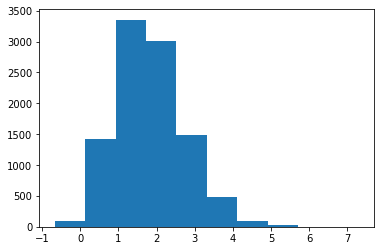

In [142]:
plt.hist(tmax_actual)

In [143]:
alpha=0.05

In [144]:
critical_thresh = np.percentile(tmax_actual, 95)

In [145]:
critical_thresh

3.4318943272937847

Significant sig_segments will hold the significant ones

In [146]:
sig_segments = np.where(np.array(stat) > critical_thresh)

In [147]:
sig_segments

(array([], dtype=int64),)